In [1]:
excel = '/content/WCNiFine-4D-80nm-150x150_filtered.xlsx'
sheet_name = 'Test 1'

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
import scipy
from sklearn import mixture

df = pd.read_excel(excel, sheet_name=sheet_name)
df.dropna(subset=['HARDNESS'], inplace=True)
df = df.iloc[1:]
X = df[['HARDNESS','MODULUS']].values.reshape(-1, 2)
X.shape

(22437, 2)

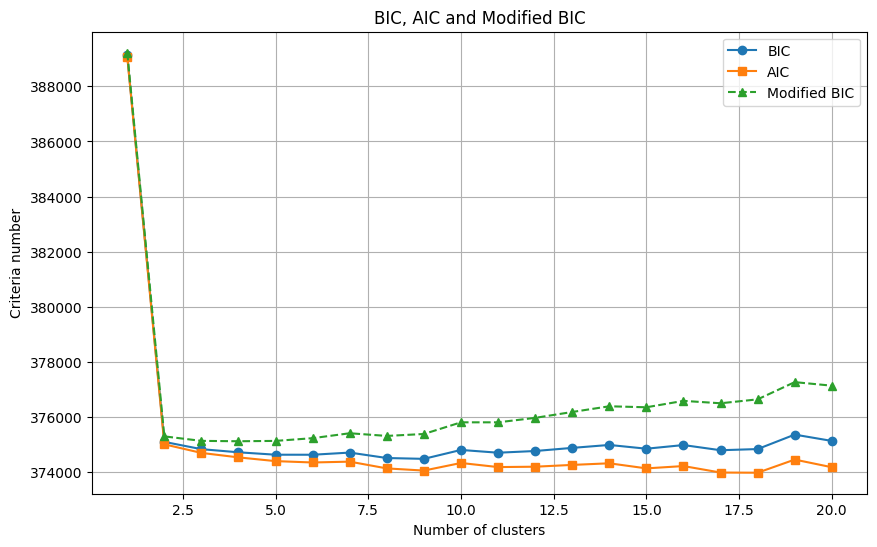

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture

NMAX = 20
bic = []
aic = []
mbic = []

n_samples = X.shape[0]
n_features = X.shape[1]

# Penalization factor
penalization_factor = 10  # Increase to penalize more

# Calculate BIC, AIC and Modified BIC
for kG in np.arange(1, NMAX+1):
    gmm = mixture.GaussianMixture(n_components=kG, covariance_type='full').fit(X)
    bic_value = gmm.bic(X)
    aic_value = gmm.aic(X)

    # BIC modified: Penalization
    modified_bic_value = bic_value + penalization_factor * kG * np.log(n_samples)

    bic.append(bic_value)
    aic.append(aic_value)
    mbic.append(modified_bic_value)

# Plot BIC, AIC and Modified BIC
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, NMAX+1), bic, marker='o', label='BIC')
plt.plot(np.arange(1, NMAX+1), aic, marker='s', label='AIC')
plt.plot(np.arange(1, NMAX+1), mbic, marker='^', label='Modified BIC', linestyle='--')
plt.title('BIC, AIC and Modified BIC')
plt.xlabel('Number of clusters')
plt.ylabel('Criteria number')
plt.legend()
plt.grid(True)
plt.show()




In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture

# Fit the Gaussian Mixture Model
num_components = 3
gmm_winner = mixture.GaussianMixture(n_components=num_components, covariance_type='full').fit(X)
posterior_probs = gmm_winner.predict_proba(X)
cluster_labels = np.argmax(posterior_probs, axis=1)

# Calculate mean and standard deviation of each cluster
cluster_means = []
cluster_stds = []
cluster_sizes = []

for k in range(num_components):
    cluster_k = X[cluster_labels == k]
    cluster_means.append(np.mean(cluster_k, axis=0))
    cluster_stds.append(np.std(cluster_k, axis=0, dtype=np.float64))
    cluster_sizes.append(len(cluster_k))

# Calculate mean and standard deviation for each feature separately
hardness_cluster_means = [m[0] for m in cluster_means]
hardness_cluster_stds = [s[0] for s in cluster_stds]

modulus_cluster_means = [m[1] for m in cluster_means]
modulus_cluster_stds = [s[1] for s in cluster_stds]

# Calculate percentage of data in each cluster
total_data = len(X)
cluster_sizes = [np.sum(cluster_labels == k) for k in range(num_components)]
cluster_percentages = [100 * s / total_data for s in cluster_sizes]

# Create a DataFrame with the cluster information for both features
df_clusters = pd.DataFrame({
    'Cluster index': range(num_components),
    'Hardness mean': hardness_cluster_means,
    'Hardness std. dev.': hardness_cluster_stds,
    'Modulus mean': modulus_cluster_means,
    'Modulus std. dev.': modulus_cluster_stds,
    'Cluster size (%)': cluster_percentages
})

# Sort the DataFrame by 'Hardness mean' to reorder the cluster indices
df_clusters_sorted = df_clusters.sort_values(by='Hardness mean').reset_index(drop=True)

# Reassign the cluster labels based on the sorted indices
cluster_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(df_clusters_sorted['Cluster index'])}
new_cluster_labels = np.vectorize(cluster_mapping.get)(cluster_labels)

# Print means, standard deviations, and percentage of data in each cluster with 2 decimal places
for idx, row in df_clusters_sorted.iterrows():
    print(f"Cluster index {idx}:")
    print(f"    Hardness Mean = {row['Hardness mean']:.2f}, Std. dev. = {row['Hardness std. dev.']:.2f}")
    print(f"    Modulus Mean = {row['Modulus mean']:.2f}, Std. dev. = {row['Modulus std. dev.']:.2f}")
    print(f"    Cluster size (%) = {row['Cluster size (%)']:.2f}%")




Cluster index 0:
    Hardness Mean = 17.15, Std. dev. = 4.05
    Modulus Mean = 385.78, Std. dev. = 59.14
    Cluster size (%) = 22.65%
Cluster index 1:
    Hardness Mean = 21.09, Std. dev. = 4.98
    Modulus Mean = 538.24, Std. dev. = 55.58
    Cluster size (%) = 12.04%
Cluster index 2:
    Hardness Mean = 29.05, Std. dev. = 3.40
    Modulus Mean = 487.59, Std. dev. = 49.52
    Cluster size (%) = 65.31%


In [16]:
#DECIDE THE NAME AND COLORS OF THE CLUSTERS LOOKING AT THE CLUSTER INDEX DATA
cluster_names = {0: '0', 1: '1', 2: '2', 3: '3', 4: '4'}
cluster_colors = {0: 'blue', 1: 'yellow', 2: 'green', 3: 'red', 4: 'magenta'}

In [ ]:
# Check the length of cluster_labels
print("Length of cluster_labels:", len(cluster_labels))

Length of cluster_labels: 39995


In [ ]:
#CREATE A NEW EXCEÑ WITH THE CLUSTER STATISTICS

# replace cluster indices with cluster names in the DataFrame
df_clusters['Cluster name'] = df_clusters['Cluster index'].map(cluster_names)
df_clusters.drop('Cluster index', axis=1, inplace=True)

# export the DataFrame to an Excel file
with pd.ExcelWriter('WC-Ni-Coarse_clustersAvg.xlsx') as writer:
    df_clusters.to_excel(writer, index=False)

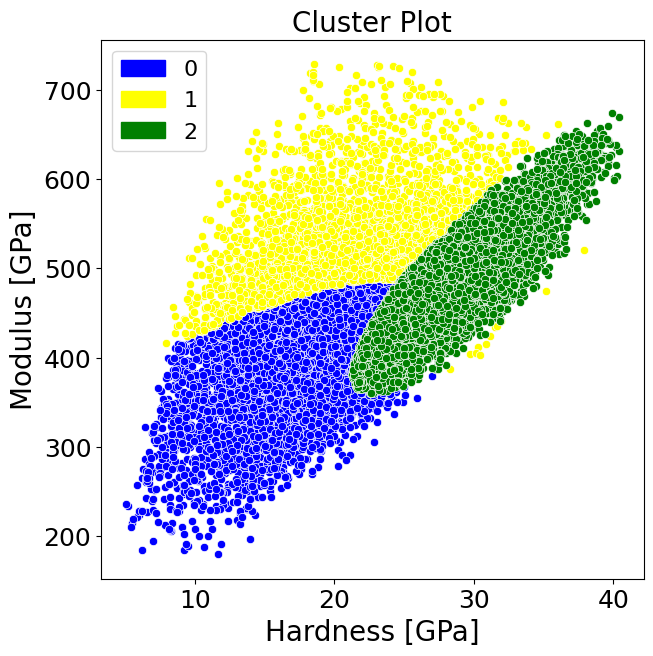

In [17]:
cluster_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(df_clusters_sorted['Cluster index'])}
new_cluster_labels = np.vectorize(cluster_mapping.get)(cluster_labels)


# Scatterplot with clusters
fig, ax = plt.subplots(figsize=(7, 7))
for k in range(num_components):
    cluster_k = X[new_cluster_labels == k]
    ax.scatter(cluster_k[:, 0], cluster_k[:, 1], c=cluster_colors[k], label=cluster_names[k],
               edgecolors='white', linewidths=0.5)

ax.set_xlabel('Hardness [GPa]', fontsize=20)
ax.set_ylabel('Modulus [GPa]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_title('Cluster Plot', fontsize=20)

import matplotlib.patches as mpatches
handles = []
labels = []

# Legend
for k in range(num_components):
    h = mpatches.Patch(color=cluster_colors[k], label=cluster_names[k])
    handles.append(h)
    labels.append(cluster_names[k])

plt.legend(handles=handles, labels=labels, fontsize=16)
plt.show()


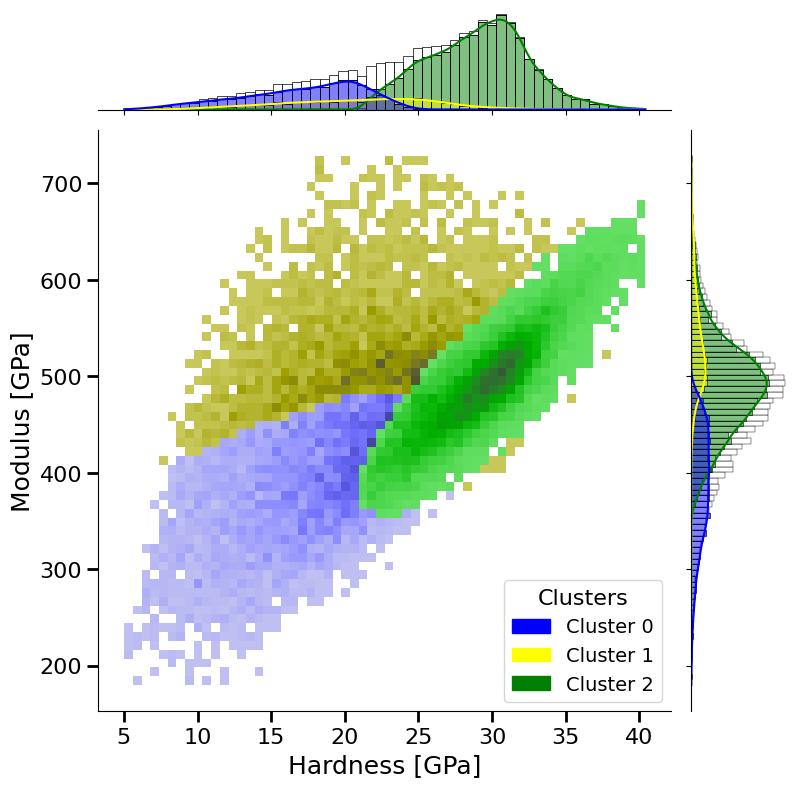

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create the jointplot and specify the cluster labels and color palette
jointplot = sns.jointplot(x='HARDNESS', y='MODULUS', data=df, color='w')

# Get the current figure and increase its size
fig = plt.gcf()
fig.set_size_inches(8, 8)

# Set the axis labels and fontsize
jointplot.set_axis_labels('Hardness [GPa]', 'Modulus [GPa]', fontsize=18)

# Modify the fontsize of the axis numbers and thickness of the ticks
jointplot.ax_joint.tick_params(axis='both', which='major', labelsize=16)
jointplot.ax_joint.tick_params(axis='both', which='major', width=2, length=8)

# Add marginal plots on the top and right sides, use the new_cluster_labels and cluster_colors
sns.histplot(data=df, x='HARDNESS', hue=new_cluster_labels, palette=cluster_colors, kde=True, ax=jointplot.ax_marg_x, legend=False)
sns.histplot(data=df, y='MODULUS', hue=new_cluster_labels, palette=cluster_colors, kde=True, ax=jointplot.ax_marg_y, legend=False)

# Overlay the density plot, again using the new_cluster_labels
sns.histplot(x='HARDNESS', y='MODULUS', data=df, hue=new_cluster_labels, palette=cluster_colors, ax=jointplot.ax_joint, stat='density', common_norm=False, bins=60, legend=False)

# Customize the legend
handles = []
for k in range(num_components):
    h = mpatches.Patch(color=cluster_colors[k], label=f"Cluster {k}")
    handles.append(h)

plt.legend(handles=handles, title="Clusters", fontsize=14, title_fontsize=16)

# Show the plot
plt.show()


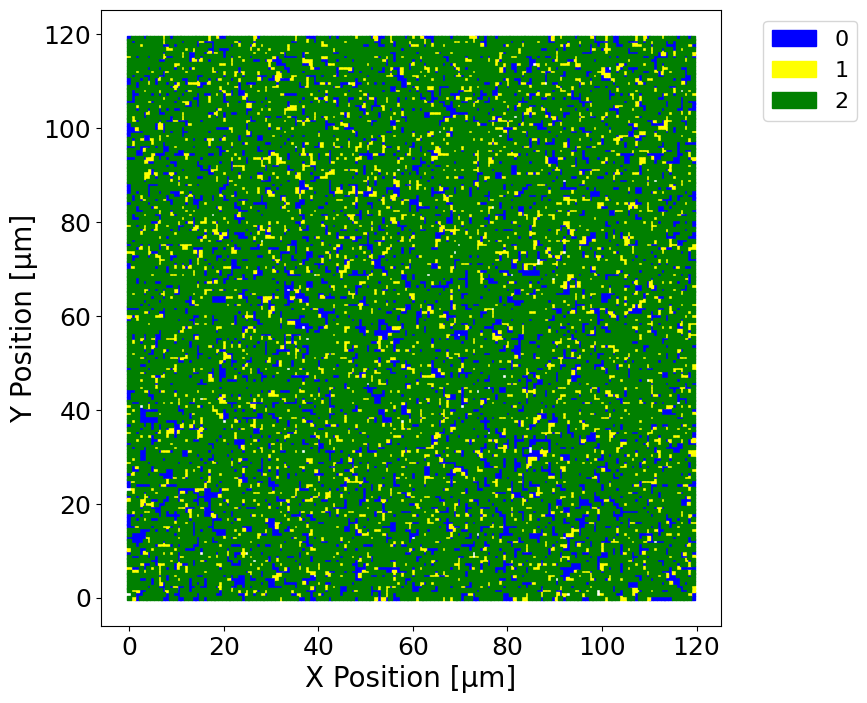

In [20]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(8, 8))
plt.gca().set_aspect('equal')

handles = []
labels = []

for k in range(num_components):
    cluster_k = df[new_cluster_labels == k]
    ax.scatter(cluster_k['X'], cluster_k['Y'], c=cluster_colors[k], label=cluster_names[k], marker='s', s=6)

    # Legend
    h = mpatches.Patch(color=cluster_colors[k], label=cluster_names[k])
    handles.append(h)
    labels.append(cluster_names[k])

ax.set_xlabel('X Position [μm]', fontsize=20)
ax.set_ylabel('Y Position [μm]', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=18)

# Set axis limits to match your data range
ax.set_xlim(df['X'].min(), df['X'].max())
ax.set_ylim(df['Y'].min(), df['Y'].max())

plt.axis('tight')

plt.legend(handles=handles, labels=labels, fontsize=16, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()
